In [1]:
"""
This notebook contains a working example show usage of the new
image classifier based saliency map API for choosing to use 
a occlusion based saliency map algorithm.

Reference for implementation: Zeiler MD, Fergus R. Visualizing 
and understanding convolutional networks. InEuropean conference
on computer vision 2014 Sep 6 (pp. 818-833). Springer, Cham.

"""
from xaitk_saliency.interfaces.perturb_image import PerturbImage
from xaitk_saliency.interfaces.vis_sal_classifier import ImageClassifierSaliencyMapGenerator
from smqtk_core.configuration import from_config_dict

import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torch.autograd import Variable
import torchvision.models as models
from sklearn.linear_model import LogisticRegression
import torch
from sklearn.preprocessing import minmax_scale
import numpy as np
from operator import itemgetter

# Test image to be explained
test_image = 'catdog.png'
# Imagenet class for which saliency maps need to be computed 
sal_classes = ['bull mastiff', 'Egyptian cat']

# Declaring xaitk implementation instantiations 

sliding_window_cfg = {
    "type": "xaitk_saliency.impls.perturb_image.occlusion.OcclusionBasedPerturb",
    "xaitk_saliency.impls.perturb_image.occlusion.OcclusionBasedPerturb": {
    "window_size": 25,
    "stride": 5,
    },
  }
occ_cfg = {
    "type": "xaitk_saliency.impls.vis_sal_classifier.occlusion_scoring.OcclusionScoring",
    "xaitk_saliency.impls.vis_sal_classifier.occlusion_scoring.OcclusionScoring": {
    },
  }

# Creating xaitk objects for sliding window and classifier based Fsal approach. 
slid_algo = from_config_dict(sliding_window_cfg, PerturbImage.get_impls())
occ_alg = from_config_dict(occ_cfg, ImageClassifierSaliencyMapGenerator.get_impls())

# Creating an example deep feature extractor to describe images
model = models.resnet18(pretrained=True)
model = model.eval()
model = model.cuda()

# Download ImageNet labels and extract id for required classes
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

# Extracting Imagenet class ID for given classes
required_class_id = []
for class_label in sal_classes:
    required_class_id.append(categories.index(class_label))

Failed to import psycopg2: No module named 'psycopg2'
Failed to import psycopg2: No module named 'psycopg2'
Failed to import psycopg2: No module named 'psycopg2'
Failed to import caffe module: No module named 'caffe'
Failed to import psycopg2: No module named 'psycopg2'


--2021-05-20 16:56:53--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt.4’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2021-05-20 16:56:54 (48.0 MB/s) - ‘imagenet_classes.txt.4’ saved [10472/10472]



In [2]:
# Input image loader to match feature extractor expectation
imsize = 224
loader = transforms.Compose([transforms.Resize((imsize)), transforms.ToTensor()])

def image_loader(image_name):
    try:
        image = Image.open(image_name)
    except AttributeError:
        # If Image already open
        image = image_name
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    return image.cuda().unsqueeze(0)

def predict_with_model(model, image_tensor):
    featureVec = model(image_tensor)
    preds_ = featureVec.cpu().detach().numpy().squeeze()
    # Returning scores for only desired class IDs
    return np.asarray(itemgetter(*required_class_id)(preds_))

def scale_heatmap(heatmap):
    # Function to scale output saliency map to range [0, 1]
    return minmax_scale(heatmap.ravel(),
                                feature_range=(0, 1)).reshape(heatmap.shape)

# Test image containing both cat and dog.
test_img = Image.open(test_image).resize((imsize, imsize))
# Compute original prediction scores on test image
org_preds = predict_with_model(model, image_loader(test_image))
dims = len(org_preds)

# Use created sliding window based perturbation algorithm to perturb test image
pert_img, pertmask = slid_algo.perturb(test_img)

# Compute classifier scores on perturbed version of the test image
prtbd_conf = [predict_with_model(model, image_loader(ptrbed)) for ptrbed in pert_img]

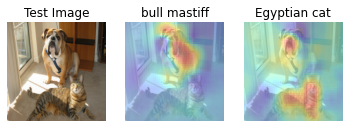

In [3]:
# Generating final saliency map for selected classes
final_saliency_maps = occ_alg.generate(org_preds, prtbd_conf, pertmask)

sub_plot_ind = len(final_saliency_maps) + 1

# Visualizing Saliency maps for both classes
plt.figure()
plt.subplot(1, sub_plot_ind, 1)
plt.imshow(test_img)
plt.axis('off')
plt.title('Test Image')

for i, class_sal_map in enumerate(final_saliency_maps):
    plt.subplot(1, sub_plot_ind, i+2)
    plt.imshow(test_img, alpha=0.5)
    plt.imshow(scale_heatmap(class_sal_map), cmap='jet', alpha=0.3)
    plt.title('{}'.format(sal_classes[i]))
    plt.axis('off')
    
plt.show()